In [1]:
import sys
sys.path.append("..")
from utils.dataset import FerDataset

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class ResidualUnit(nn.Module):
    
    def __init__(self, depth_in, depth_out):
        super(ResidualUnit, self).__init__()
        self.stride = 1
        self.relu = nn.ReLU()
        
        self.resBlock = nn.Sequential(
            nn.Conv2d(depth_in, depth_out, kernel_size=(3, 3), stride = self.stride, padding = 1),
            nn.BatchNorm2d(depth_out),
            nn.ReLU(),
            nn.Conv2d(depth_out, depth_out, kernel_size=(3, 3), stride = self.stride, padding = 1),
            nn.BatchNorm2d(depth_out)
        )
        
    def forward(self, x):
        #Residual unit
        identity = x
        
        result = self.resBlock(x)
        #Residual unit
        #print("x.shape", x.shape)
        #x = x.view(x.size(0), -1)
        
        result += identity
        result = self.relu(result)
        
        return result

In [3]:
class DownsampleResidualUnit(nn.Module):
    
    def __init__(self, depth_in, depth_out):
        super(DownsampleResidualUnit, self).__init__()
        self.stride = 2
        self.relu = nn.ReLU()
        
        self.resBlock = nn.Sequential(
            nn.Conv2d(depth_in, depth_out, kernel_size=(3, 3), stride = self.stride, padding = 1),
            nn.BatchNorm2d(depth_out),
            nn.ReLU(),
            nn.Conv2d(depth_out, depth_out, kernel_size=(3, 3), stride = 1, padding = 1),
            nn.BatchNorm2d(depth_out)
        )
        
        self.matchDim = nn.Sequential(
            nn.Conv2d(depth_in, depth_out, kernel_size=(1,1), stride=self.stride, padding = 0),
            # this is required to match the dimensions of the identity x with F(x), because
            # in this block the first of the two convolutionl layers performs downsamlpling and therefore
            # changes the dimensions of the activation volume.
            nn.BatchNorm2d(depth_out)
        )
        
        
    def forward(self, x):
        #Downsample unit
        identity = x
        
        result = self.resBlock(x)
        #Downsample unit
        #print("x.shape", x.shape)
        #x = x.view(x.size(0), -1)
        
        
        identity = self.matchDim(identity)
        
        
        result += identity
        result = self.relu(result)
        
        return result

In [4]:
class IncreaseDepthKeepSizeUnit(nn.Module):
# This class is required when retaining the spatial dimension (height, width) but increasing depth. We cannot use the
# Basic Block because there the dimensions of the skip connection do not match with the output.
    
    def __init__(self, depth_in, depth_out):
        super(IncreaseDepthKeepSizeUnit, self).__init__()
        # here is the difference to DownsampleUnit: self.stride is 1, such that height and width remains
        # unchanged, but depth can be changed.
        self.stride = 1
        self.relu = nn.ReLU()
        
        self.resBlock = nn.Sequential(
            nn.Conv2d(depth_in, depth_out, kernel_size=(3, 3), stride = self.stride, padding = 1),
            nn.BatchNorm2d(depth_out),
            nn.ReLU(),
            nn.Conv2d(depth_out, depth_out, kernel_size=(3, 3), stride = 1, padding = 1),
            nn.BatchNorm2d(depth_out)
        )
        
        self.matchDim = nn.Sequential(
            nn.Conv2d(depth_in, depth_out, kernel_size=(1,1), stride=self.stride, padding = 0),
            # this is required to match the dimensions of the identity x with F(x), because
            # in this block the first of the two convolutionl layers performs downsamlpling and therefore
            # changes the dimensions of the activation volume.
            nn.BatchNorm2d(depth_out)
        )
        
        
    def forward(self, x):
        #Downsample unit
        identity = x
        
        result = self.resBlock(x)
        #Downsample unit
        #print("x.shape", x.shape)
        #x = x.view(x.size(0), -1)
        
        
        identity = self.matchDim(identity)
        
        
        result += identity
        result = self.relu(result)
        
        return result

In [5]:
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
# https://arxiv.org/pdf/1512.03385.pdf

In [6]:
class ResNet(nn.Module):
    
    def __init__(self):
        super(ResNet, self).__init__()
        
        self.convnet = nn.Sequential(
            # 48 x 48 x 1
            nn.Conv2d(1, 64, kernel_size=(7, 7), stride = 2, padding = 3),
            # 7 x 7, out_depth=64, stride=2 are given by the paper. The output has to be 24 x 24 x 64.
            # Therefore the padding ist calculated via: P = ((width_out-1) * stride + filter_size - width_in)/2
            # instead of width_in and width_out one can also use height_in and height_out
            # ((24-1)*2+7-48)/2 = P = 2.5, i.e. we choose padding = 3
            
            # 24 x 24 x 64
            
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding = 1),
            # MaxPool with kernel = (3,3) and stride=2 is given by the paper
            # P = ((12-1) * 2 + 3 - 24)/2 = 0.5, i.e. P=1
            
            # 12 x 12 x 64
            ResidualUnit(64, 64),
            ResidualUnit(64, 64), 
            ResidualUnit(64, 64), 
            
            DownsampleResidualUnit(64, 128),
            # 6 x 6 x 128
            ResidualUnit(128, 128),
            ResidualUnit(128, 128),
            ResidualUnit(128, 128),
            
            DownsampleResidualUnit(128, 256),
            # 3 x 3 x 256
            ResidualUnit(256, 256),
            ResidualUnit(256, 256),
            ResidualUnit(256, 256),
            ResidualUnit(256, 256),
            ResidualUnit(256, 256),
            
            # instead of DownsampleResidualUnit(256, 512),
            IncreaseDepthKeepSizeUnit(256, 512),
            # 3 x 3 x 512
            ResidualUnit(512, 512),
            ResidualUnit(512, 512),
            
            #nn.AdaptiveAvgPool2d(1)  
            nn.AvgPool2d(kernel_size = (3,3), stride=1, padding=0)         
            # width_out = (width_in - F + 2P)/S+1
            # = (3 - 3 + 0)/2 + 1 = 1
            # 1 x 1 x 512
        )
        
        
        self.fc = nn.Sequential(
            nn.Linear(512, 10)        
        )
        
        
    def forward(self, x):
        x = self.convnet(x)
        #print("x.shape", x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
        

In [7]:
# i have to check dimension and padding of: the first convolutional layer and the max pooling 

In [8]:
dataset = FerDataset(base_path='../../data',
                     data='ferplus',
                     mode='train',
                     label='ferplus_votes')
dataloader = DataLoader(dataset, batch_size=24, shuffle=True, num_workers=0)
net = ResNet()
log_softmax = nn.LogSoftmax(dim=-1)
criterion = nn.KLDivLoss(size_average=False)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [9]:
x_batch, y_batch = next(iter(dataloader))
print(x_batch.shape)

torch.Size([6, 1, 48, 48])


(48, 48)


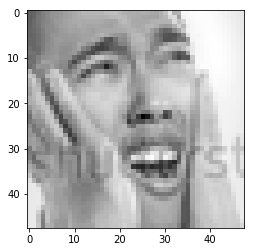

In [10]:
image = x_batch[3].numpy()
image = image.reshape(48, 48) # make it from 1x48x48 to 48 x48
print(image.shape)
plt.imshow(image,cmap = plt.get_cmap('gray'))
plt.show()

In [11]:
losses = []
#for i in range(1000):
for i in range(50):
    optimizer.zero_grad()
    logits = net(x_batch)
    log_probs = log_softmax(logits)
    loss = criterion(log_probs, y_batch)
    losses.append(float(loss))
    loss.backward()
    optimizer.step()
    print(i, end='\r')

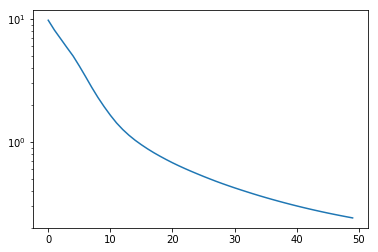

In [12]:
plt.plot(losses)
plt.yscale('log')

(48, 48)


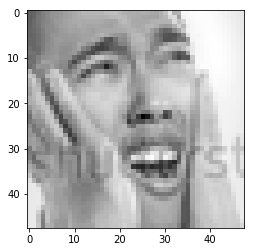

In [13]:
image = x_batch[3].numpy()
image = image.reshape(48, 48) # make it from 1x48x48 to 48 x48
print(image.shape)
plt.imshow(image,cmap = plt.get_cmap('gray'))
plt.show()

In [18]:
print(y_batch)
# for each picture there are 10 possible labels (emotions). Each label was voted by several humans, therefore, 
# several of these 10 layers can have a value higher than 0 (but not greater than 1)

tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.9000,  0.1000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.9000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.1000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.9000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.1000,  0.0000],
        [ 0.8000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.2000,  0.0000]])


In [19]:
print(net.named_parameters)
# (string, Parameter) – Tuple containing the name and parameter

<bound method Module.named_parameters of ResNet(
  (convnet): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): ResidualUnit(
      (relu): ReLU()
      (resBlock): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (5): ResidualUnit(
      (relu): ReLU()
      (resBlock): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [9]:
def train(model, optim, dataloader, loss_function, lr = 0.0001, step_size = 0, opt_params = None,use_gpu = False):
    """
    train the model and return the losses and learning rates
    
    Args:
        model: (torch.nn.Module): the neural network we want to train
        optim: (torch.optim): the optimzier we want to use for training 
        dataloader: (DataLoader): the dataloader of the training set over which we want to iterate
        loss_function: (torch.nn.modules.loss.): the chosen loss function for our optimization problem
        lr: (int): the learning rate for the optimizer
        step_size: (int): the step_size with which we want to increase the learning rate for every new match
                          in order to find out the optimal learning rate when plotting loss vs learning rates
        opt_params: (int or list): the remaining parameters for the optimzier (the other two arguments are the
                                   learning rate and model.parameters()). In case of SGD this is only the momentum
        use_gpu: (bool): if we want to train on the gpu    
    """
        
    # set model, i.e. the NN into train mode. This is required for some specific layers that show different 
    # behaviour in train and test time such as dropout or batchnorm. Batchnorm e.g. uses the batch mean and batch 
    # variance (i.e. sample mean and variance) at train time and population mean and population variance at test time.
    model = model.train()
    
    losses = []
    
    learning_rates = []
    
    optimizer = optim(model.parameters(), lr, opt_params)
    
    if use_gpu:
        model.cuda()
    
    for i, (x_batch, y_batch) in enumerate(dataloader):
        
                
        # Use GPU if available:
        if use_gpu:
            x_batch, y_batch = x_batch.cuda(async=True), y_batch.cuda(async=True)
          
        # our last layer in the network should perform softmax classification
        log_softmax = nn.LogSoftmax(dim=-1)
            
        # calculate loss
        logits = model(x_batch)
        log_probs = log_softmax(logits)
        loss = loss_function(log_probs, y_batch)
        
        lr = (lr+step_size)
        optimizier = optim(model.parameters(), lr, opt_params)
        learning_rates.append(float(lr))
        
        # set gradient for this iteration to zero so that it doesnt accumulate over training
        optimizer.zero_grad()
        
        # calculate gradients in backwardpass
        loss.backward()
        
        # add loss to array losses
        losses.append(float(loss))
        
        # update the weights with the calculated gradients
        optimizer.step()
        
        print(i, end='\r')
    return losses, learning_rates

In [10]:
optimizer = torch.optim.SGD

losses, learning_rates = train(net, optimizer, dataloader, criterion, 0.0001, 0.0001, 0.9) 

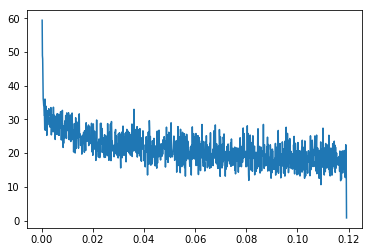

In [11]:
plt.plot(learning_rates, losses)

In [14]:
import csv


csvfile = "lr_SGD_0.0001_0.0001_0.9.csv"

#Assuming res is a flat list
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in learning_rates:
        writer.writerow([val])  

In [15]:
csvfile = "losses_SGD_0.0001_0.0001_0.9.csv"

#Assuming res is a flat list
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in losses:
        writer.writerow([val])  